Implemente LVQ1, LVQ2.1 e LVQ3.

a. Adotar o classificador k-NN, k = {1,3} com distância Euclidiana;

b. Varie o número de protótipos;

c. Avalie usando dois bancos de dados do repositório Promise;

d. Compare com os resultados sem o uso de seleção de protótipos.

In [1]:
import pandas as pd
import numpy as np
import random

import math
import matplotlib.pyplot as plt 

from sklearn.neighbors import  KNeighborsClassifier

from sklearn.model_selection import GridSearchCV


from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from time import time
import io
from scipy.io import arff
import urllib.request

from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
def onlineArff(url):
    
    
    ftpstream = urllib.request.urlopen(url)
    data, meta = arff.loadarff(io.StringIO(ftpstream.read().decode('utf-8')))

    df = pd.DataFrame(data)

    df.iloc[:,-1] = df.iloc[:,-1].apply(lambda x: str(x)[1:]) #Retirando caractere indesejado
    X  = df.iloc[:, :-1] # retirando a última coluna, pois é o target
    
    y = df.iloc[:,-1] # target

    return X,y

In [3]:
def readArff(file):
    data = arff.loadarff(file)
    df = pd.DataFrame(data[0])
    
    df.iloc[:,-1] = df.iloc[:,-1].apply(lambda x: str(x)[1:]) #Retirando caractere indesejado
    
    X  = df.iloc[:, :-1] # retirando a última coluna, pois é o target
    
    y = df.iloc[:,-1] # target
    y = y.map({"'true'": True, "'false'": False})
    #display(y)
    return X,y

In [4]:
def getBarplot(data, title, y_label, color, proportions  ):
    
    
    i_aux = 1
    index = []
    
    for row in data:
        aux = []
        for value in row:
            aux.append(i_aux)
            i_aux = i_aux + 1
        
        index.append(aux)
    
    print(index)
    
    fig,ax = plt.subplots()
    width = 0.3
    
    plt.title(title)
    plt.ylabel(y_label)
    
    
    aux = np.arange(index[-1][-1] +1)
    
    #labels = ['KNN', 'LVQ1', 'LVQ2', 'LVQ3']
    rect = [None] * len(data)
    text = [""]
    for i in range(len(data)):
        rect[i] =  plt.bar(index[i] , data[i], width=width, color=color)        
        
        text.append('KNN')
        text.append('LVQ1')
        text.append('LVQ2')
        text.append('LVQ3')
        
    plt.xticks(aux , text)
    
    
        
    plt.savefig("images/"+title+".png")
    plt.show()

In [5]:
def getAccuracy(X_train, y_train, X_test, y_test, estimator, parameters,scorer, name ):

    start = time()
    grid_obj = GridSearchCV(estimator, parameters,cv=5,scoring=scorer, return_train_score =True)
    grid_fit = grid_obj.fit(X_train, y_train.values.ravel())
      
    best_clf = grid_fit.best_estimator_
        
    best_predictions = pd.DataFrame(best_clf.predict(X_test))
    
    acc = accuracy_score(y_test,best_predictions)
    #print ("f1Score: ",f1_score(y_test,best_predictions))
    end = time()
    print(name, " accuracy: ", round(acc,2))
    print(name, " test time: ", round(end -start,2))
    return acc, (end- start)

In [6]:
class LVQ:
    def __init__(self, X, y, lvq_type="1", proportion = 0.01, learning_rate = 0.1, iterations=10, random_state = 200):
        
        start = time()
        self.X = X
        self.y = y 
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.proportion = proportion
        self.random_state = random_state
        self.getPrototypes()
        self.getClasses()
        self.lvq_type = lvq_type
        self.k = 1
        
        
        if (self.lvq_type == "1"):
            
            self.prototypes = self.lvq1()
            
            
            
        elif (self.lvq_type == "2_1"):
            
            self.prototypes = self.lvq2()
            
            
            
        elif (self.lvq_type == "3"):
            
            self.prototypes = self.lvq3()
            
            
        end = time()
        self.time_prot = end - start

        print("Tempo de geração de protótipos: ",round(self.time_prot,2))
        
    def getMinDistances(self,row_df):
        """
        1. Calcula a distância da linha recebida com todas linhas dos protótipos
        2. Para cada k:
            2.1 São guardadas as k menores distâncias 
            2.2 São guardados também os indexes das menores distâncias do grupo de protótipos
        São retornadas as k menores (melhores) distâncias e os indexes do protótipos
        """
        
        distances = np.array([])
        best_match = np.array([])
        index = np.array([])
        
        for index_pt, row_pt in self.prototypes_X.iterrows():

            distances = np.append(distances, self.euclideanDistance(row_df, row_pt))

        for i in range(self.k):
            best_match = np.append( best_match , np.partition(distances, i)[i])  # o elemento '0' é o com menor distancia
    
            index = np.append(index,np.where(distances == best_match[i])[0]) #retornando o primeiro elemento só

        index = index.astype(int)
        
        
        return (best_match , index)
    
    def euclideanDistance(self, vector1, vector2):
        return np.sqrt(np.sum(np.power(vector1-vector2, 2)))

 
    
    def getPrototypes(self):
        self.prototypes_X = self.X.sample(frac=self.proportion, replace=True,random_state = self.random_state)
        
    
    def getClasses(self):
        classes = np.array([])
        aux_index = np.array([])
    
        for index, row in self.prototypes_X.iterrows():
            classes = np.append(classes, self.y[index])
            aux_index = np.append(aux_index, index)
    
        aux_index = aux_index.astype(int)
        self.prototype_classes = pd.DataFrame(data =  classes, index = aux_index)
    
    
    def lvq1(self):
        """
    LVQ1
    1. Escolher protótipos
    2. Pegar index dos protótipos da base de treinamento
    3. Saber a classe do protótipo pelo index obtido
    4. Para todos os elementos da base de treinamento
        4.1 Obter a distância e o index do protótipo mais próximo
        4.2 Caso sejam da mesma classe aproximá-los, se não afastá-los
    
    """
        prototypes = self.prototypes_X
        self.k = 1
        #display(self.prototypes_X)
        for i in range(self.iterations):
            rate = self.learning_rate * math.exp(-i/float(self.iterations)) # decaimento
        
            for index_X, row_X in self.X.iterrows():
                d, iBestMatch = self.getMinDistances(row_X)
                
            ###matches, iBestMatch = best_match[::2], best_match[1::2] # matches contém as menores distâncias e os indexes contém o index no X_t em que se tem a menor distância
                for i in range(self.k):
                    
                    if self.y.iloc[index_X] == self.y.iloc[iBestMatch[i]]:
                        prototypes.iloc[iBestMatch[i]] = prototypes.iloc[iBestMatch[i]] + (rate * (self.X.iloc[index_X] - prototypes.iloc[iBestMatch[i]]))
                    else:
                        prototypes.iloc[iBestMatch[i]] = prototypes.iloc[iBestMatch[i]] - (rate * (self.X.iloc[index_X] - prototypes.iloc[iBestMatch[i]]))
            
        return prototypes
    
    
    
    
    def lvq2(self):
        """
    LVQ2
    X é a base de treino, x é um elemento da base de treino
    1. Escolher protótipos iniciais usando LVQ1
    2. Pegar index dos protótipos da base de treinamento
    3. Saber a classe do protótipo pelo index obtido
    4. Para todos os elementos da base de treinamento
        4.1 Obter a distância e o index dos 2 protótipos mais próximos (ei, ej)
        4.2 Se cair na janela(x, ei, ej)
                Se Classe(ei) != Classe(ej)
                    Se Classe (ei) == Classe(x)
                        Aproxima ei e afasta ej
                    Se não
                        Aproxima ej e afasta ei
        
    """
        prototypes = self.lvq1()
        self.k = 2
        self.window = 0.3
        
        for i in range(self.iterations):
            rate = self.learning_rate * math.exp(-i/float(self.iterations)) # decaimento
            for index_X, row_X in self.X.iterrows():
                d, iBestMatch = self.getMinDistances(row_X)
                if (d[0] !=0 and d[1] !=0): #Checar se eh 0 ou sera feito uma divisao por 0 inapropriada
                    aux_d = min(d[0]/d[1], d[1]/d[0])
                    s = (1 - self.window)/ (1+ self.window)
                    if (aux_d > s ): #Janela
                        
                        if self.y.iloc[iBestMatch[0]] != self.y.iloc[iBestMatch[1]]:
                            if self.y.iloc[index_X] == self.y.iloc[iBestMatch[0]]:
                                prototypes.iloc[iBestMatch[0]] = prototypes.iloc[iBestMatch[0]] + (rate * (self.X.iloc[index_X] - prototypes.iloc[iBestMatch[0]]))
                                prototypes.iloc[iBestMatch[1]] = prototypes.iloc[iBestMatch[1]] - (rate * (self.X.iloc[index_X] - prototypes.iloc[iBestMatch[1]]))
                                       
                            else:
                                prototypes.iloc[iBestMatch[1]] = prototypes.iloc[iBestMatch[1]] - (rate * (self.X.iloc[index_X] - prototypes.iloc[iBestMatch[1]]))
                                prototypes.iloc[iBestMatch[1]] = prototypes.iloc[iBestMatch[1]] + (rate * (self.X.iloc[index_X] - prototypes.iloc[iBestMatch[1]]))               
                  
        return prototypes    
        
        
    def lvq3(self):
        """
    LVQ3
    X é a base de treino, x é um elemento da base de treino
    
    1. Escolher protótipos iniciais usando LVQ1
    2. Pegar index dos protótipos da base de treinamento
    3. Saber a classe do protótipo pelo index obtido
    4. Para todos os elementos da base de treinamento
        4.1 Obter a distância e o index dos 2 protótipos mais próximos (ei, ej)
        4.2 Se cair na janela(x, ei, ej)
                Se Classe(ei) != Classe(ej)
                    Se Classe (ei) == Classe(x)
                        Aproxima ei e afasta ej
                    Se não
                        Aproxima ej e afasta ei
                Se Classe(ei) == Classe(ej) == Classe(x)
                estabiliza ei e ej com epsilon
                        
    """
    
        prototypes = self.lvq1()
        self.k = 2
        self.window = 0.3
        self.epsilon = 0.05
        
        
        for i in range(self.iterations):
            rate = self.learning_rate * math.exp(-i/float(self.iterations)) # decaimento
            for index_X, row_X in self.X.iterrows():
                d, iBestMatch = self.getMinDistances(row_X)
                if (d[0] !=0 and d[1] !=0): #Checar se eh 0 ou sera feito uma divisao por 0 inapropriada
                    aux_d = min(d[0]/d[1], d[1]/d[0])
                    s = (1 - self.window)/ (1+ self.window)
                    if (aux_d > s ): #Janela
                        
                        if self.y.iloc[iBestMatch[0]] != self.y.iloc[iBestMatch[1]]:
                            if self.y.iloc[index_X] == self.y.iloc[iBestMatch[0]]:
                                prototypes.iloc[iBestMatch[0]] = prototypes.iloc[iBestMatch[0]] + (rate * (self.X.iloc[index_X] - prototypes.iloc[iBestMatch[0]]))
                                prototypes.iloc[iBestMatch[1]] = prototypes.iloc[iBestMatch[1]] - (rate * (self.X.iloc[index_X] - prototypes.iloc[iBestMatch[1]]))
                                       
                            else:
                                prototypes.iloc[iBestMatch[0]] = prototypes.iloc[iBestMatch[0]] - (rate * (self.X.iloc[index_X] - prototypes.iloc[iBestMatch[0]]))
                                prototypes.iloc[iBestMatch[1]] = prototypes.iloc[iBestMatch[1]] + (rate * (self.X.iloc[index_X] - prototypes.iloc[iBestMatch[1]]))               
                        
                        elif self.y.iloc[iBestMatch[0]] == self.y.iloc[iBestMatch[1]] == self.y.iloc[index_X]:
                            
                            prototypes.iloc[iBestMatch[0]] = prototypes.iloc[iBestMatch[0]] + (self.epsilon* (rate * (self.X.iloc[index_X] - prototypes.iloc[iBestMatch[0]])))
                            prototypes.iloc[iBestMatch[1]] = prototypes.iloc[iBestMatch[1]] + (self.epsilon* (rate * (self.X.iloc[index_X] - prototypes.iloc[iBestMatch[1]])))
        
        return prototypes                    
        

(498, 21)

Train Data  accuracy:  0.87
Train Data  test time:  0.32
Número de protótipos:  10
Tempo de geração de protótipos:  13.38
Tempo de geração de protótipos:  21.57
Tempo de geração de protótipos:  25.73
LVQ1  accuracy:  0.87
LVQ1  test time:  0.04
LVQ2  accuracy:  0.87
LVQ2  test time:  0.05
LVQ3  accuracy:  0.87
LVQ3  test time:  0.04
Número de protótipos:  25
Tempo de geração de protótipos:  25.54
Tempo de geração de protótipos:  47.84
Tempo de geração de protótipos:  51.91
LVQ1  accuracy:  0.87
LVQ1  test time:  0.05
LVQ2  accuracy:  0.87
LVQ2  test time:  0.05
LVQ3  accuracy:  0.87
LVQ3  test time:  0.05
Número de protótipos:  50
Tempo de geração de protótipos:  47.1
Tempo de geração de protótipos:  94.43
Tempo de geração de protótipos:  100.05
LVQ1  accuracy:  0.8
LVQ1  test time:  0.11
LVQ2  accuracy:  0.8
LVQ2  test time:  0.05


/home/pgdock/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/pgdock/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/pgdock/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/pgdock/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The def

LVQ3  accuracy:  0.81
LVQ3  test time:  0.06
[[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]


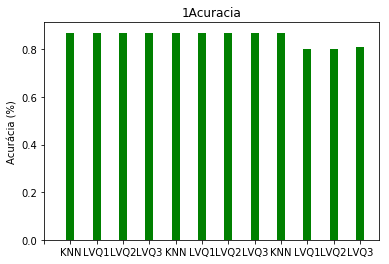

[[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]


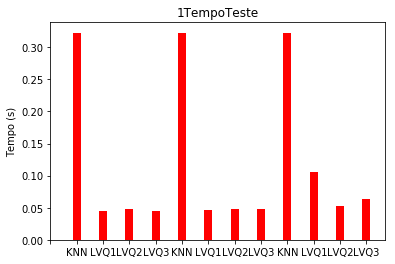

[[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]


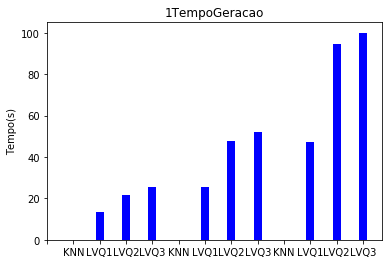

(2109, 21)

Train Data  accuracy:  0.86
Train Data  test time:  0.61
Número de protótipos:  42
Tempo de geração de protótipos:  180.11
Tempo de geração de protótipos:  429.41
Tempo de geração de protótipos:  353.21
LVQ1  accuracy:  0.85
LVQ1  test time:  0.06
LVQ2  accuracy:  0.85
LVQ2  test time:  0.06
LVQ3  accuracy:  0.79
LVQ3  test time:  0.06
Número de protótipos:  105


/home/pgdock/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/pgdock/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/pgdock/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Tempo de geração de protótipos:  413.18
Tempo de geração de protótipos:  801.8
Tempo de geração de protótipos:  824.91
LVQ1  accuracy:  0.82
LVQ1  test time:  0.07
LVQ2  accuracy:  0.82
LVQ2  test time:  0.07


/home/pgdock/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/pgdock/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/pgdock/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


LVQ3  accuracy:  0.84
LVQ3  test time:  0.07
Número de protótipos:  211
Tempo de geração de protótipos:  845.79
Tempo de geração de protótipos:  1663.21
Tempo de geração de protótipos:  1726.69
LVQ1  accuracy:  0.85
LVQ1  test time:  0.09
LVQ2  accuracy:  0.86
LVQ2  test time:  0.1


/home/pgdock/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/pgdock/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/pgdock/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


LVQ3  accuracy:  0.86
LVQ3  test time:  0.1
[[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]


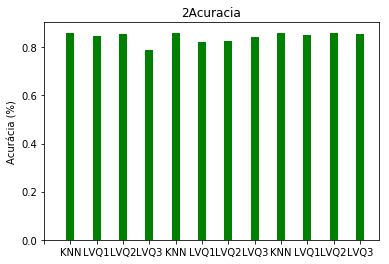

[[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]


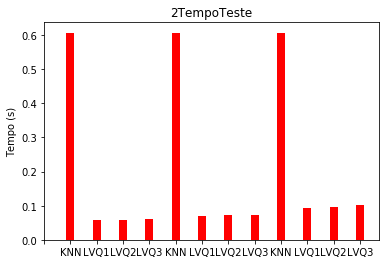

[[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]


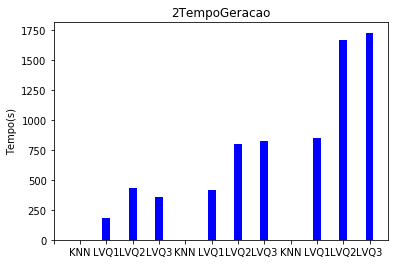

In [7]:
#urls = ["http://promise.site.uottawa.ca/SERepository/datasets/cm1.arff","http://promise.site.uottawa.ca/SERepository/datasets/kc1.arff"]
files = ["./Data/cm1.arff","./Data/kc1.arff"]
#files = ["./Data/cm1.arff"]
proportions = [0.02, 0.05, 0.1]

for index,file in enumerate(files):
    #X, y = onlineArff(url)
    X,y = readArff(file)
    columns = X.columns
    display (X.shape)
    
        
        
    scaler = preprocessing.StandardScaler()

    X = scaler.fit_transform(X)
    X = pd.DataFrame(data=X, columns= columns)
    

    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = 100)
    
    
    X_train.reset_index(drop=True, inplace=True) #São resetados, pois no LVQ é feito alterações a partir do index
    y_train.reset_index(drop=True, inplace=True)

    estimator = KNeighborsClassifier()
    parameters = {'n_neighbors':list(range(1,3)), 'metric':["euclidean"]}
    scorer = 'accuracy'
    
     
    acc_aux, test_time_aux = getAccuracy(X_train, y_train, X_test, y_test, estimator, parameters, scorer, "Train Data")
    
    
    all_test_time = []
    all_acc = []
    all_time_prot = []
    
    for proportion in proportions:
        test_time = []
        acc = []
        time_prot = []
        
        acc.append(acc_aux)
        test_time.append(test_time_aux)
        
        print("Número de protótipos: ", round(X.shape[0] * proportion))
        
        LVQ1 = LVQ(X_train,y_train,lvq_type= "1", proportion= proportion)
        
        LVQ2 = LVQ(X_train,y_train, lvq_type= "2_1",proportion= proportion)
        
        LVQ3 = LVQ(X_train,y_train, lvq_type= "3", proportion= proportion)
        
        
        acc_aux2, test_time_aux2 = getAccuracy(LVQ1.prototypes, LVQ1.prototype_classes, X_test, y_test, estimator, parameters, scorer, "LVQ1")
        acc.append(acc_aux2)
        test_time.append(test_time_aux2)
        
        acc_aux2, test_time_aux2 = getAccuracy(LVQ2.prototypes, LVQ2.prototype_classes, X_test, y_test, estimator, parameters, scorer, "LVQ2")
        acc.append(acc_aux2)
        test_time.append(test_time_aux2)

        acc_aux2, test_time_aux2 = getAccuracy(LVQ3.prototypes, LVQ3.prototype_classes, X_test, y_test, estimator, parameters, scorer, "LVQ3")
        acc.append(acc_aux2)
        test_time.append(test_time_aux2)

        
    
        time_prot.append(0) #O elemento do knn é 0
        time_prot.append(LVQ1.time_prot)
        time_prot.append(LVQ2.time_prot)
        time_prot.append(LVQ3.time_prot)
        
        all_test_time.append(test_time)
        all_acc.append(acc)
        all_time_prot.append(time_prot)
        
    getBarplot(all_acc,str(index+1)+"Acuracia", "Acurácia (%)", "green", proportions)
    getBarplot(all_test_time,str(index+1)+"TempoTeste", "Tempo (s)", "red", proportions)
    getBarplot(all_time_prot, str(index+1)+"TempoGeracao", "Tempo(s)", "blue", proportions )

    
   

In [8]:


#Add gráficos de barra para o tempo
#Gráficos para a acurácia
    #    self.lvq1()# Baixar arquivos Arff que vou fazer teste, pois o offline deu erro uma vez

## Fazer a seleção de protótipos randomicamente com o pandas

